## Global setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

torch.manual_seed(123)
np.random.seed(123)

Using device: cuda


## Data prep and class examples

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.10MB/s]


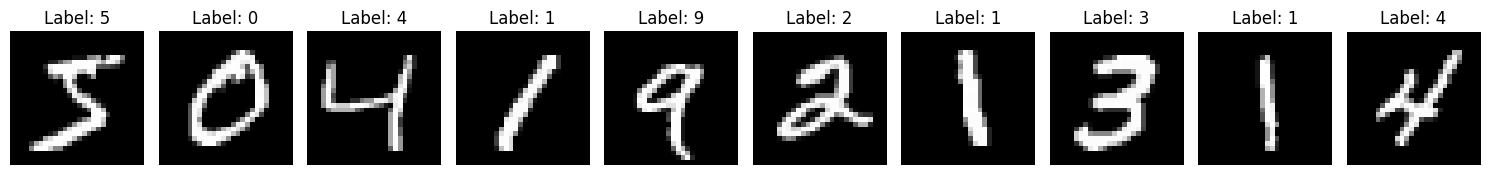

In [ ]:
###MNIST hyperparameters###
batch_size = 128
image_size = 28
num_classes = 10

#normalize data to [-1, 1] for diffusion
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#plot some samples to see what we're working with
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Diffusion setup

simplified diffusion process with a linear noise schedule.

In [ ]:
class LinearDiffusion:

    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.timesteps = timesteps
        self.device = device

        #linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=self.device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0).to(self.device)

        #diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        #posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)).to(self.device)


    #add noise to samples in forward diffusion
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].to(x_start.device)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].to(x_start.device)

        #reshape
        sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.reshape(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    #denoise with reverse diffusion, with classifier guidance if applicable
    def p_sample(self, model, x_t, t, classifier=None, class_label=None, guidance_scale=0.0):
        batch_size = x_t.shape[0]

        #get model prediction
        t_tensor = torch.full((batch_size,), t, device=x_t.device, dtype=torch.long)

        #predict noise
        if guidance_scale > 0 and classifier is not None and class_label is not None:


            # IMPORTANT! Here is where we implement classifier guidance
            with torch.enable_grad():
                x_t_grad = x_t.detach().requires_grad_(True)
                logits = classifier(x_t_grad, t_tensor)
                log_probs = F.log_softmax(logits, dim=-1)
                selected = log_probs[range(len(logits)), class_label]
                grad = torch.autograd.grad(selected.sum(), x_t_grad)[0]

            #apply guidance scale
            predicted_noise = model(x_t, t_tensor)
            predicted_noise = predicted_noise - guidance_scale * grad * self.sqrt_one_minus_alphas_cumprod[t].to(x_t.device)
        else:
            #unconditional prediction
            predicted_noise = model(x_t, t_tensor)

        #x_{t-1}
        alpha_t = self.alphas[t].to(x_t.device)
        alpha_cumprod_t = self.alphas_cumprod[t].to(x_t.device)
        beta_t = self.betas[t].to(x_t.device)

        #predict x_0
        x_0_pred = (x_t - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)
        x_0_pred = torch.clamp(x_0_pred, -1.0, 1.0)

        #calculate mean
        model_mean = (x_t - beta_t / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_t)

        if t == 0:
            return model_mean
        else:
            #add noise
            posterior_variance_t = self.posterior_variance[t].to(x_t.device)
            noise = torch.randn_like(x_t)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

#init
diffusion = LinearDiffusion(timesteps=1000, device=device)
print(f'Diffusion timesteps: {diffusion.timesteps}')

Diffusion timesteps: 1000


### Recap of forward diffusion

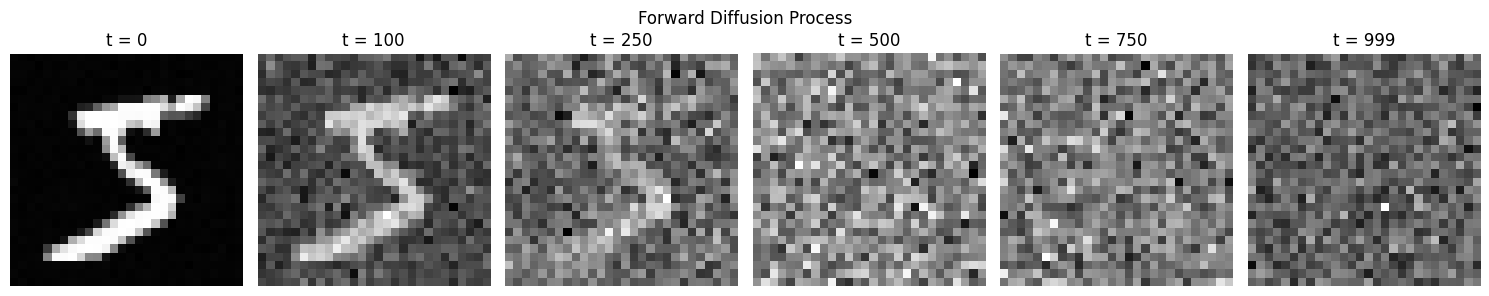

In [ ]:
#forward diffusion on a sample image
sample_img, _ = train_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

timesteps_to_show = [0, 100, 250, 500, 750, 999]
fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))

for idx, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=device)
    noisy_img = diffusion.q_sample(sample_img, t_tensor)

    axes[idx].imshow(noisy_img.cpu().squeeze(), cmap='gray')
    axes[idx].set_title(f't = {t}')
    axes[idx].axis('off')

plt.suptitle('Forward Diffusion Process')
plt.tight_layout()
plt.show()

## Lightweight diffusion model

I am using a simplified time-embedded UNet architecture here, and leaving out some of the architectural improvements the authors made, because it would take too long and cost too much to run a full model. This demo will just show how classifier guidance works and how different levels affect diversity vs fidelity of samples

In [ ]:
class SinusoidalPositionEmbedding(nn.Module):
    """Sinusoidal position embeddings for time steps"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ResidualBlock(nn.Module):
    """Residual block with time embedding (FIXED for GroupNorm)"""

    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        num_groups = min(8, out_channels)
        while out_channels % num_groups != 0:
            num_groups -= 1

        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t_emb):

        h = self.conv1(F.relu(x))
        h = self.norm1(h)

        #add time embedding
        h = h + self.time_mlp(F.relu(t_emb))[:, :, None, None]

        h = self.conv2(F.relu(h))
        h = self.norm2(h)

        return h + self.shortcut(x)


class LightweightUNet(nn.Module):
    """Lightweight U-Net for denoising (~1M parameters) - FIXED"""

    def __init__(self, in_channels=1, model_channels=64, time_emb_dim=128):
        super().__init__()

        #time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Encoder (downsampling)
        self.enc1 = ResidualBlock(in_channels, model_channels, time_emb_dim)
        self.down1 = nn.Conv2d(model_channels, model_channels, 3, stride=2, padding=1)

        self.enc2 = ResidualBlock(model_channels, model_channels * 2, time_emb_dim)
        self.down2 = nn.Conv2d(model_channels * 2, model_channels * 2, 3, stride=2, padding=1)

        # Bottleneck
        self.bottleneck = ResidualBlock(model_channels * 2, model_channels * 2, time_emb_dim)

        # Decoder (upsampling)
        self.up1 = nn.ConvTranspose2d(model_channels * 2, model_channels * 2, 4, stride=2, padding=1)
        self.dec1 = ResidualBlock(model_channels * 4, model_channels * 2, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(model_channels * 2, model_channels, 4, stride=2, padding=1)
        self.dec2 = ResidualBlock(model_channels * 2, model_channels, time_emb_dim)

        # Output
        self.out = nn.Conv2d(model_channels, in_channels, 1)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t)

        # Encoder
        h1 = self.enc1(x, t_emb)          # (B, 64, 28, 28)
        h2 = self.enc2(self.down1(h1), t_emb)  # (B, 128, 14, 14)

        # Bottleneck
        h = self.bottleneck(self.down2(h2), t_emb)  # (B, 128, 7, 7)

        # Decoder with skip connections
        h = self.dec1(torch.cat([self.up1(h), h2], dim=1), t_emb)  # Concat at 14x14
        h = self.dec2(torch.cat([self.up2(h), h1], dim=1), t_emb)  # Concat at 28x28

        return self.out(h)


#init
unet = LightweightUNet(in_channels=1, model_channels=64).to(device)

num_params = sum(p.numel() for p in unet.parameters())
print(f'U-Net params: {num_params:,}')

U-Net params: 1,819,713


## Lightweight Classifier for Guidance

Also using a more basic classifier for the same reasons, trained to classify MNIST into the 10 classes with added noise

In [ ]:
class TimeConditionedClassifier(nn.Module):
    """simple classifier"""

    def __init__(self, num_classes=10, time_emb_dim=128):
        super().__init__()

        # Time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Time modulation layers
        self.time_mlp1 = nn.Linear(time_emb_dim, 32)
        self.time_mlp2 = nn.Linear(time_emb_dim, 64)
        self.time_mlp3 = nn.Linear(time_emb_dim, 128)

        # Classification head
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t)

        # Conv blocks with time modulation
        h = F.relu(self.conv1(x))
        h = h + self.time_mlp1(t_emb)[:, :, None, None]
        h = self.pool(h)

        h = F.relu(self.conv2(h))
        h = h + self.time_mlp2(t_emb)[:, :, None, None]
        h = self.pool(h)

        h = F.relu(self.conv3(h))
        h = h + self.time_mlp3(t_emb)[:, :, None, None]
        h = self.pool(h)

        # Flatten and classify
        h = h.view(h.size(0), -1)
        h = F.relu(self.fc1(self.dropout(h)))
        h = self.fc2(self.dropout(h))

        return h


#init
classifier = TimeConditionedClassifier(num_classes=num_classes).to(device)

num_params_clf = sum(p.numel() for p in classifier.parameters())
print(f'Classifier parameters: {num_params_clf:,}')

Classifier parameters: 435,818


## 6. Training Loop

Train both the diffusion model and the classifier for 30 epochs

In [ ]:
# Training hyperparameters
num_epochs = 30
lr = 2e-4

# Optimizers
optimizer_unet = torch.optim.Adam(unet.parameters(), lr=lr)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=lr)

# Loss function
mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()


### Train UNet

In [ ]:
def train_diffusion_model(model, dataloader, optimizer, diffusion, epochs):
    """Train the diffusion model to predict noise"""
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, _) in enumerate(pbar):
            images = images.to(device)
            batch_size = images.shape[0]

            # Sample random timesteps
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

            # Sample noise
            noise = torch.randn_like(images)

            # Add noise to images
            x_noisy = diffusion.q_sample(images, t, noise=noise)

            # Predict noise
            predicted_noise = model(x_noisy, t)

            # Calculate loss
            loss = mse_loss(predicted_noise, noise)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1} - Average Loss: {avg_loss:.4f}')

# Train U-Net
train_diffusion_model(unet, train_loader, optimizer_unet, diffusion, num_epochs)

Epoch 1/30: 100%|██████████| 469/469 [00:35<00:00, 13.17it/s, loss=0.0326]


Epoch 1 - Average Loss: 0.1115


Epoch 2/30: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s, loss=0.0395]


Epoch 2 - Average Loss: 0.0384


Epoch 3/30: 100%|██████████| 469/469 [00:34<00:00, 13.40it/s, loss=0.0338]


Epoch 3 - Average Loss: 0.0331


Epoch 4/30: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s, loss=0.0295]


Epoch 4 - Average Loss: 0.0301


Epoch 5/30: 100%|██████████| 469/469 [00:35<00:00, 13.14it/s, loss=0.0273]


Epoch 5 - Average Loss: 0.0288


Epoch 6/30: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s, loss=0.0312]


Epoch 6 - Average Loss: 0.0278


Epoch 7/30: 100%|██████████| 469/469 [00:36<00:00, 12.96it/s, loss=0.0303]


Epoch 7 - Average Loss: 0.0269


Epoch 8/30: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s, loss=0.0334]


Epoch 8 - Average Loss: 0.0264


Epoch 9/30: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s, loss=0.0235]


Epoch 9 - Average Loss: 0.0259


Epoch 10/30: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s, loss=0.0249]


Epoch 10 - Average Loss: 0.0252


Epoch 11/30: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s, loss=0.0293]


Epoch 11 - Average Loss: 0.0253


Epoch 12/30: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s, loss=0.0253]


Epoch 12 - Average Loss: 0.0247


Epoch 13/30: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s, loss=0.0338]


Epoch 13 - Average Loss: 0.0245


Epoch 14/30: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s, loss=0.0221]


Epoch 14 - Average Loss: 0.0243


Epoch 15/30: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s, loss=0.0238]


Epoch 15 - Average Loss: 0.0243


Epoch 16/30: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s, loss=0.0248]


Epoch 16 - Average Loss: 0.0238


Epoch 17/30: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s, loss=0.0212]


Epoch 17 - Average Loss: 0.0238


Epoch 18/30: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s, loss=0.0254]


Epoch 18 - Average Loss: 0.0238


Epoch 19/30: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s, loss=0.0232]


Epoch 19 - Average Loss: 0.0236


Epoch 20/30: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s, loss=0.0262]


Epoch 20 - Average Loss: 0.0237


Epoch 21/30: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s, loss=0.0205]


Epoch 21 - Average Loss: 0.0233


Epoch 22/30: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s, loss=0.0242]


Epoch 22 - Average Loss: 0.0233


Epoch 23/30: 100%|██████████| 469/469 [00:36<00:00, 12.78it/s, loss=0.0204]


Epoch 23 - Average Loss: 0.0231


Epoch 24/30: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s, loss=0.0256]


Epoch 24 - Average Loss: 0.0233


Epoch 25/30: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s, loss=0.0272]


Epoch 25 - Average Loss: 0.0231


Epoch 26/30: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s, loss=0.0239]


Epoch 26 - Average Loss: 0.0230


Epoch 27/30: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s, loss=0.0250]


Epoch 27 - Average Loss: 0.0228


Epoch 28/30: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s, loss=0.0256]


Epoch 28 - Average Loss: 0.0226


Epoch 29/30: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s, loss=0.0233]


Epoch 29 - Average Loss: 0.0228


Epoch 30/30: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s, loss=0.0224]

Epoch 30 - Average Loss: 0.0227


even without full architecture in place, this is pretty good performance!

### Train Classifier

In [ ]:
def train_classifier(model, dataloader, optimizer, diffusion, epochs):
    """Train classifier to classify noisy images at various timesteps"""
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(dataloader, desc=f'Classifier Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]

            # Sample random timesteps (focus on earlier timesteps for better classification)
            t = torch.randint(0, diffusion.timesteps // 2, (batch_size,), device=device).long()

            # Add noise to images
            noise = torch.randn_like(images)
            x_noisy = diffusion.q_sample(images, t, noise=noise)

            # Classify
            logits = model(x_noisy, t)
            loss = ce_loss(logits, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})

        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        print(f'Classifier Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Train classifier
train_classifier(classifier, train_loader, optimizer_clf, diffusion, num_epochs)

Classifier Epoch 1/30: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s, loss=0.5852, acc=58.77%]


Classifier Epoch 1 - Loss: 1.1894, Accuracy: 58.77%


Classifier Epoch 2/30: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s, loss=0.4152, acc=83.98%]


Classifier Epoch 2 - Loss: 0.4900, Accuracy: 83.98%


Classifier Epoch 3/30: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s, loss=0.2751, acc=86.32%]


Classifier Epoch 3 - Loss: 0.4111, Accuracy: 86.32%


Classifier Epoch 4/30: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s, loss=0.2581, acc=87.47%]


Classifier Epoch 4 - Loss: 0.3767, Accuracy: 87.47%


Classifier Epoch 5/30: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s, loss=0.2455, acc=88.01%]


Classifier Epoch 5 - Loss: 0.3592, Accuracy: 88.01%


Classifier Epoch 6/30: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s, loss=0.4920, acc=88.57%]


Classifier Epoch 6 - Loss: 0.3449, Accuracy: 88.57%


Classifier Epoch 7/30: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s, loss=0.2627, acc=89.08%]


Classifier Epoch 7 - Loss: 0.3301, Accuracy: 89.08%


Classifier Epoch 8/30: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s, loss=0.3009, acc=89.25%]


Classifier Epoch 8 - Loss: 0.3242, Accuracy: 89.25%


Classifier Epoch 9/30: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s, loss=0.4597, acc=89.45%]


Classifier Epoch 9 - Loss: 0.3217, Accuracy: 89.45%


Classifier Epoch 10/30: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s, loss=0.2708, acc=89.61%]


Classifier Epoch 10 - Loss: 0.3109, Accuracy: 89.61%


Classifier Epoch 11/30: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s, loss=0.3373, acc=89.75%]


Classifier Epoch 11 - Loss: 0.3083, Accuracy: 89.75%


Classifier Epoch 12/30: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s, loss=0.3393, acc=90.12%]


Classifier Epoch 12 - Loss: 0.2988, Accuracy: 90.12%


Classifier Epoch 13/30: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s, loss=0.2645, acc=90.18%]


Classifier Epoch 13 - Loss: 0.2972, Accuracy: 90.18%


Classifier Epoch 14/30: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s, loss=0.2624, acc=90.23%]


Classifier Epoch 14 - Loss: 0.2947, Accuracy: 90.23%


Classifier Epoch 15/30: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s, loss=0.2964, acc=90.42%]


Classifier Epoch 15 - Loss: 0.2912, Accuracy: 90.42%


Classifier Epoch 16/30: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s, loss=0.3230, acc=90.54%]


Classifier Epoch 16 - Loss: 0.2868, Accuracy: 90.54%


Classifier Epoch 17/30: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s, loss=0.1654, acc=90.37%]


Classifier Epoch 17 - Loss: 0.2882, Accuracy: 90.37%


Classifier Epoch 18/30: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s, loss=0.1963, acc=90.45%]


Classifier Epoch 18 - Loss: 0.2869, Accuracy: 90.45%


Classifier Epoch 19/30: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s, loss=0.2641, acc=90.81%]


Classifier Epoch 19 - Loss: 0.2813, Accuracy: 90.81%


Classifier Epoch 20/30: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s, loss=0.3398, acc=90.71%]


Classifier Epoch 20 - Loss: 0.2842, Accuracy: 90.71%


Classifier Epoch 21/30: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s, loss=0.2157, acc=90.75%]


Classifier Epoch 21 - Loss: 0.2790, Accuracy: 90.75%


Classifier Epoch 22/30: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s, loss=0.1676, acc=90.92%]


Classifier Epoch 22 - Loss: 0.2759, Accuracy: 90.92%


Classifier Epoch 23/30: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s, loss=0.4024, acc=90.94%]


Classifier Epoch 23 - Loss: 0.2760, Accuracy: 90.94%


Classifier Epoch 24/30: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s, loss=0.4419, acc=91.01%]


Classifier Epoch 24 - Loss: 0.2694, Accuracy: 91.01%


Classifier Epoch 25/30: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s, loss=0.1962, acc=91.03%]


Classifier Epoch 25 - Loss: 0.2707, Accuracy: 91.03%


Classifier Epoch 26/30: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s, loss=0.2809, acc=90.98%]


Classifier Epoch 26 - Loss: 0.2691, Accuracy: 90.98%


Classifier Epoch 27/30: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s, loss=0.2299, acc=91.17%]


Classifier Epoch 27 - Loss: 0.2677, Accuracy: 91.17%


Classifier Epoch 28/30: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s, loss=0.2796, acc=91.02%]


Classifier Epoch 28 - Loss: 0.2679, Accuracy: 91.02%


Classifier Epoch 29/30: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s, loss=0.2439, acc=91.20%]


Classifier Epoch 29 - Loss: 0.2660, Accuracy: 91.20%


Classifier Epoch 30/30: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s, loss=0.3511, acc=91.29%]

Classifier Epoch 30 - Loss: 0.2609, Accuracy: 91.29%


Also very good performance, especially considering I am feeding it noisy images

In [ ]:
torch.save(unet.state_dict(), 'unet.pth')
torch.save(classifier.state_dict(), 'classifier.pth')

## 7. Sampling


In [2]:
@torch.no_grad()
def sample_images(model, diffusion, classifier=None, class_labels=None,
                 guidance_scale=0.0, num_samples=16, image_size=28):
    """Generate images from noise using the diffusion model"""
    model.eval()
    if classifier is not None:
        classifier.eval()

    # Start from random noise
    x = torch.randn(num_samples, 1, image_size, image_size, device=device)

    # If class labels not provided, sample randomly
    if class_labels is None and guidance_scale > 0:
        class_labels = torch.randint(0, num_classes, (num_samples,), device=device)

    # Reverse diffusion process
    for t in tqdm(reversed(range(diffusion.timesteps)), desc='Sampling', total=diffusion.timesteps):
        x = diffusion.p_sample(model, x, t, classifier, class_labels, guidance_scale)

    return x, class_labels


### Demo: How Classifier Guidance Scales affect sample quality and diversity

- s = 0.0: unconditional sampling, using entire dataset rather than referencing specific class
- s = 1.0: for a fully trained and well-built guided diffusion model, this is the standard scale, guides towards a specific class but doesn't overly limit diversity of samples
  - for this model, this is still too little becuase of limited training and incomplete architecture
- s = 5.0: typically a strong guidance scale, would tend to prefer fidelity over diversity
- s = 10.0: very strong guidance
- s = 10000: asymptotic performance towards fidelity, opposite of unconditional where we are basically only replicating preexisting training images


In [ ]:
guidance_scales = [0.0, 1.0, 5.0, 10, 10000]
fixed_class = 4

classifier.load_state_dict(torch.load('classifier.pth'))
unet.load_state_dict(torch.load('unet.pth'))

samples_per_scale = 16
class_labels_fixed = torch.full((samples_per_scale,), fixed_class, device=device)

all_samples = {}
all_labels = {}

for s in guidance_scales:
    print(f'\nguidance scale s={s}')
    samples, labels = sample_images(
        unet,
        diffusion,
        classifier=classifier if s > 0 else None,
        class_labels=class_labels_fixed if s > 0 else None,
        guidance_scale=s,
        num_samples=samples_per_scale
    )
    all_samples[s] = samples.cpu()
    all_labels[s] = labels.cpu() if labels is not None else None


guidance scale s=0.0


Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 267.77it/s]



guidance scale s=1.0


Sampling: 100%|██████████| 1000/1000 [00:08<00:00, 120.70it/s]



guidance scale s=5.0


Sampling: 100%|██████████| 1000/1000 [00:09<00:00, 108.25it/s]



guidance scale s=10


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 160.86it/s]



guidance scale s=10000


Sampling: 100%|██████████| 1000/1000 [00:05<00:00, 175.81it/s]


## Visual Comparison


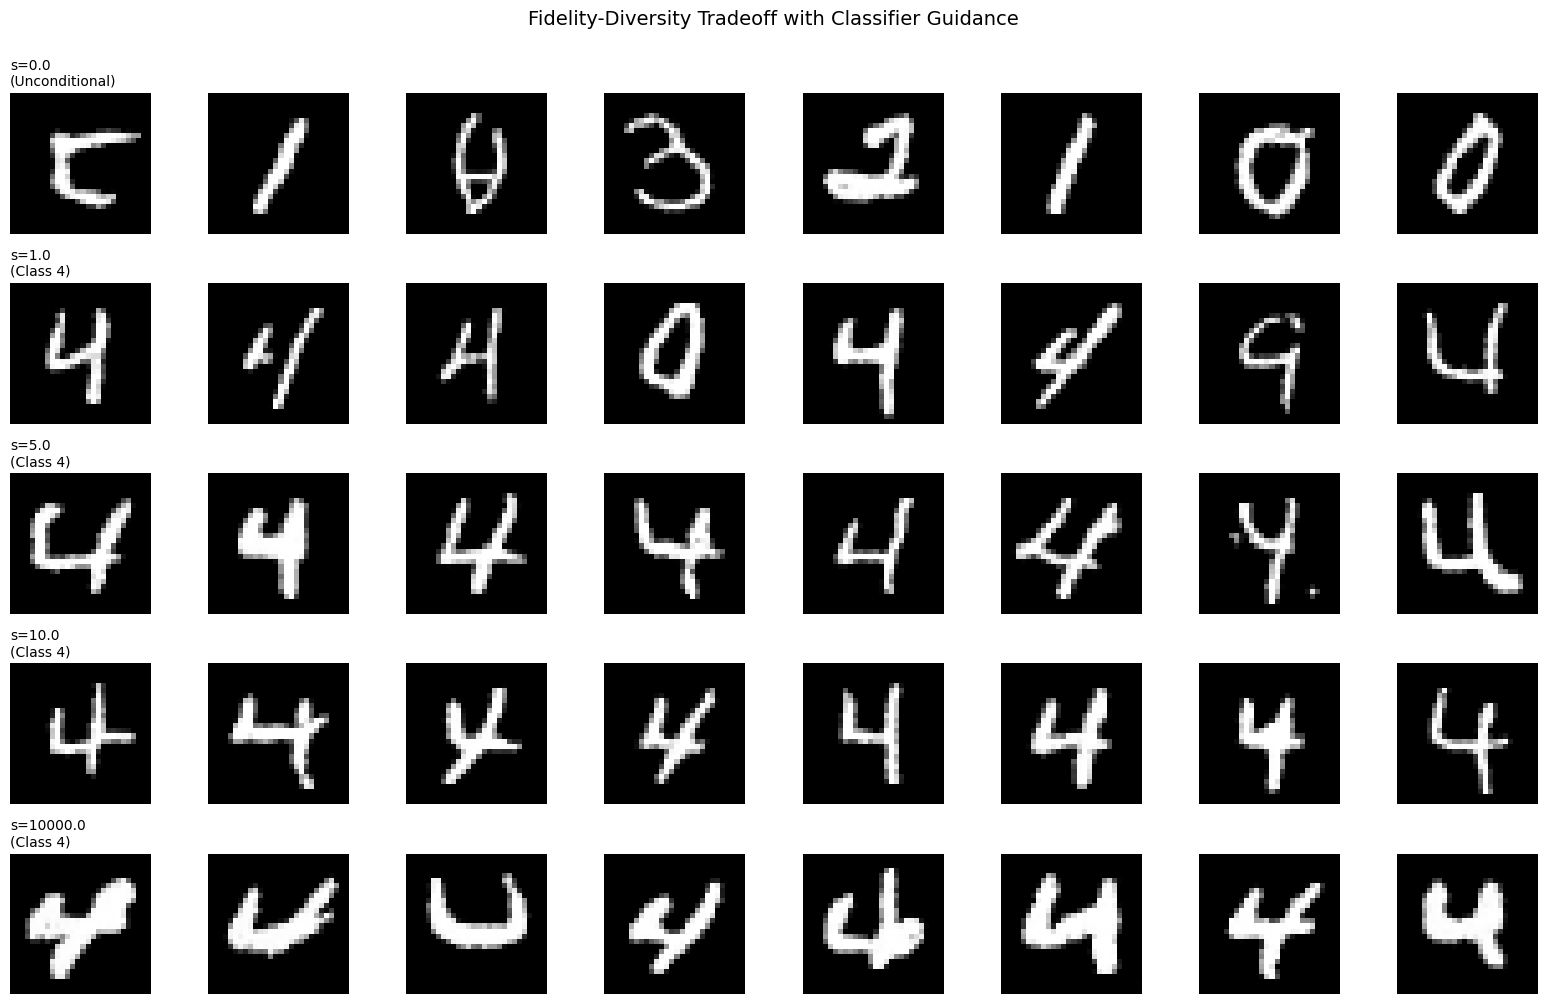

In [ ]:
# Create visualization grid
fig, axes = plt.subplots(len(guidance_scales), 8, figsize=(16, 2*len(guidance_scales)))

for row_idx, s in enumerate(guidance_scales):
    samples = all_samples[s]
    labels = all_labels[s]

    for col_idx in range(8):
        img = samples[col_idx].squeeze()
        # Denormalize from [-1, 1] to [0, 1]
        img = (img + 1) / 2
        img = torch.clamp(img, 0, 1)

        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')

        if col_idx == 0:
            if s == 0:
                title = f's={s:.1f}\n(Unconditional)'
            else:
                title = f's={s:.1f}\n(Class {fixed_class})'
            axes[row_idx, col_idx].set_title(title, fontsize=10, loc='left')

plt.suptitle('Fidelity-Diversity Tradeoff with Classifier Guidance', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

As scale increases, samples become less diverse, referencing a specific class more closely, and by s = 10000 are overfitted because the diversity is too low and you have lost too much conditional information

### Side-by-Side Comparison

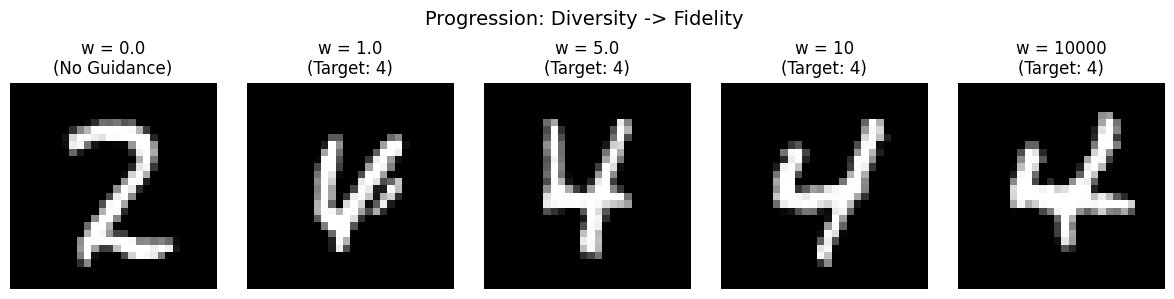

In [ ]:
# Show single example from each guidance scale
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(12, 3))

for idx, w in enumerate(guidance_scales):
    img = all_samples[w][0].squeeze()
    img = (img + 1) / 2  # Denormalize
    img = torch.clamp(img, 0, 1)

    axes[idx].imshow(img, cmap='gray')
    if w == 0:
        axes[idx].set_title(f'w = {w}\n(No Guidance)', fontsize=12)
    else:
        axes[idx].set_title(f'w = {w}\n(Target: {fixed_class})', fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Progression: Diversity -> Fidelity \n', fontsize=14)
plt.tight_layout()
plt.show()

As a reminder: This demonstration does not use many of the architectural improvements that the paper outlines, which would all increase performance and reduce the level of classifier guidance needed for quality samples. However, even without these improvements, this shows how important classifier guidance is towards quality samples